# Attention More

Remind that in our previous notebook `13_attention_2_concise.ipynb`, we have defined the Nadaraya-Watson kernel regression as follows:

$$
f(\mathbf{q}) = \mathbf{v}^\top \mathrm{softmax}\left(-\frac{1}{2}(\mathbf{q}^\top - \mathbf{k})^2\right),
$$

- where $\mathbf{q} \in \mathbb{R}^{m \times 1}$ 
 are the queries, $\mathbf{k} \in \mathbb{R}^{n \times 1}$ are keys, $\mathbf{v} \in \mathbb{R}^{n \times 1}$ are values.
- Actually, the  $\mathbf{k} \in \mathbb{R}^{n \times 1}$ just means that we have $n$ keys, and each key is a $1$-dimensional vector(for the function we fit just unary function).

> 算了不打算用英文继续写了，虽然看起来很好看；

注意到假如说我们从`key`到`value`的映射如果不希望是一个一对一的关系（好比我们之前拟合的函数就是一对一，`x`和`y`的维度都是1），而是多对多的关系（比如神经网络有`d`个输入然后有`v`个输出），那么我们可以这样**扩展**：
- $\mathrm{query} \in \mathbb{R}^{d}$
- $\mathrm{key} \in \mathbb{R}^{d}$
- $\mathrm{value} \in \mathbb{R}^{v}$
- $f(\mathrm{query})$ is a $v$-dimensional vector.

注意到这里的$\mathrm{query}$和$\mathrm{key}$的维度是一样的，当我们有$n$个$(key, value)$和$1$个$\mathrm{query}$的时候，我们可以这样定义：
- $\mathrm{query} \in \mathbb{R}^{d}$
- $\mathrm{keys} \in \mathbb{R}^{n \times d}$
- $\mathrm{values} \in \mathbb{R}^{n \times v}$
- $f(\mathrm{query})$ is a $v$-dimensional vector.

我们知道这种情况下我们在注意力回归中每输入一个$d$维$\mathrm{query}$，我们就会得到一个$v$维的新的$\mathrm{value}$，那么我们，很显然地会想到假如有`m`个$d$维的$\mathrm{query}$，我们就会得到`m`个$v$维的新的$\mathrm{value}$，那么我们就可以这样定义：
- $\mathrm{queries} \in \mathbb{R}^{m \times d}$
- $\mathrm{keys} \in \mathbb{R}^{n \times d}$
- $\mathrm{values} \in \mathbb{R}^{n \times v}$
- $f(\mathrm{queries})$ is a $m \times v$ matrix.

In [1]:
import torch

m, n = 5, 10
d, v = 5, 2
queries = torch.arange(m * d).reshape(m, d)
queries

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])

In [2]:
keys = torch.arange(n * d).reshape(n, d)
keys

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49]])

In [3]:
values = torch.arange(n * v).reshape(n, v)
values

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19]])

## Gaussian Kernel Attention

这里我们依然采用**高斯核**的方法来求得注意力回归的结果，我们和前面一样：

- 先求得$\mathrm{queries}$和$\mathrm{keys}$的距离矩阵$\mathbf{D} \in \mathbb{R}^{m \times n}$，其中
  $$
  \mathbf{D}_{ij} = \|\mathrm{queries}_i - \mathrm{keys}_j\|^2
  $$
- 然后我们对$\mathbf{D}$的每一行做softmax，得到$\mathbf{A} \in \mathbb{R}^{m \times n}$，其中
  $$
  \mathbf{A}_{ij} = \frac{\exp(-\mathbf{D}_{ij})}{\sum_{k=1}^n \exp(-\mathbf{D}_{ik})}
  $$
  （注意我们这里不是乘以$-\frac{1}{2}$了而是乘$-1$，从结果而言会看到$-1$拟合的更好）
- 最后我们得到$\mathrm{values}$的加权和，其中
  $$
  f(\mathrm{queries}) = \mathbf{A} \mathrm{values}
  $$

In [4]:
dists = queries.reshape(m, 1, d) - keys.reshape(1, n, d)
dists.shape # (m, n, d)

torch.Size([5, 10, 5])

In [5]:
dists = dists.square().sum(axis=2)
dists.shape # (m, n)

torch.Size([5, 10])

In [6]:
import torch.nn.functional as F

# dists should times -1

attention_weights = F.softmax(
    -1 * dists.to(torch.float32), 
    dim=1
)

In [7]:
new_values = torch.matmul(
    attention_weights, 
    values.to(torch.float32)
)

In [8]:
new_values

tensor([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.],
        [8., 9.]])

In [9]:
# 汇总上面的操作，我们可以得出一个多元注意力回归的例子
def attention_Gaussian(queries, keys):
    """
    多元注意力回归

    Parameters
    ----------
    @param queries: torch.Tensor
        queries, shape (m, d)
    @param keys: torch.Tensor
        keys, shape (n, d)
    @returns: torch.Tensor
        attention_weights, shape (m, n)
    """
    d = queries.shape[-1]
    m = queries.shape[0]
    n = keys.shape[0]

    dists = queries.reshape(m, 1, d) - keys.reshape(1, n, d)
    dists = dists.square().sum(axis=2)

    return F.softmax(
        -1 * dists.to(torch.float32), 
        dim=1
    )

In [10]:
import matplotlib.pyplot as plt

def show_attention(attention):
    """
    画出注意力权重图

    Parameters
    ----------
    @param attention: torch.Tensor
        attention weights, shape (m, n)
    """

    fig = plt.figure(figsize=(5, 5))

    pcm = plt.imshow(
        attention.detach().numpy(), 
        cmap='Reds'
    )

    plt.xlabel('Key points')
    plt.ylabel('Query points')
    plt.title('Attention weights')
    fig.colorbar(pcm, shrink=0.7)
    plt.show()

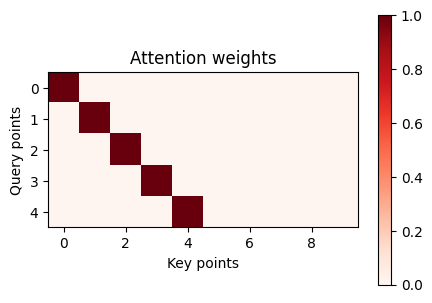

In [11]:
show_attention(attention_Gaussian(queries, keys))

## Dot Product Attention

$$
f(\mathrm{\mathbf Q}) = \mathrm{softmax}(-\mathbf{D}) \mathrm{\mathbf V}
$$

在上面式子中，我们发现在求`softmax`之前需要对距离乘与一个`-1`，这是因为我们是根据**相似度**来从之前的数据预测之后的数据的，所以距离越大，那么我们就会认为与之前的数据**相似度**越低，经过`softmax`之后得到的概率也就越低，所以这里要乘`-1`，而计算**相似度**不止求距离这一种方法；

我们知道，假如我们的$\mathrm{query}$和$\mathrm{key}$都是单位向量，那么我们可以用**点积**来表示两个向量的**相似度**（前面是通过**求距离**的方法，实际上**点积**减少了计算量，而且在`Transoformer`原论文中就是用的这一种方法），那么我们就可以这样定义：

$$
f(\mathrm{\mathbf Q}) = \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V 
$$

> 其中$\mathbf Q$就是之前的$\mathrm{queries}$，$\mathbf K$就是之前的$\mathrm{keys}$，$\mathbf V$就是之前的$\mathrm{values}$，$d$就是$\mathrm{queries}$和$\mathrm{keys}$的第二个维度；

- $\mathbf Q \in \mathbb{R}^{m \times d}$
- $\mathbf K \in \mathbb{R}^{n \times d}$
- $\mathbf V \in \mathbb{R}^{n \times v}$
- $f(\mathrm{\mathbf Q}) \in \mathbb{R}^{m \times v}$

### Why **Dot Product** Attention

一开始需要先理解下面这句话：

> 假如我们的$\mathrm{query}$和$\mathrm{key}$都是单位向量，那么我们可以用**点积**来表示两个向量的**相似度**

回想起我们之前学过的余弦相似度：

$$
\mathrm{similarity}(\mathbf x, \mathbf y) = \frac{\mathbf x^\top \mathbf y}{\|\mathbf x\| \|\mathbf y\|}
$$

- 首先我们知道，假如我们的$\mathbf x$和$\mathbf y$都是单位向量，那么我们可以用**点积**来表示两个向量的**相似度**，因为此时$\|\mathbf x\| = \|\mathbf y\| = 1$；
- 其次，我们发现了余弦相似度是不对向量的长度（范数）敏感的，因为我们求的只是$\cos(\theta)$，只与两个向量之间的夹角大小有关；
 
在我们的上面的$f(\mathrm{\mathbf Q})$中，之所以在`softmax`里面的点积我们不除以向量的模长，则是因为在softmax的作用，所有的值都会被压缩到0到1之间，同样也起到了不对向量的长度（范数）敏感的作用；而除以$\sqrt{d}$在原论文中则是说为了保证数值稳定性；

tensor([[1.0000, 0.9147, 0.8785, 0.8615, 0.8519, 0.8456, 0.8412, 0.8380, 0.8355,
         0.8335],
        [0.9147, 1.0000, 0.9966, 0.9932, 0.9909, 0.9892, 0.9880, 0.9870, 0.9863,
         0.9857],
        [0.8785, 0.9966, 1.0000, 0.9994, 0.9986, 0.9979, 0.9973, 0.9969, 0.9965,
         0.9962],
        [0.8615, 0.9932, 0.9994, 1.0000, 0.9998, 0.9995, 0.9992, 0.9990, 0.9988,
         0.9986],
        [0.8519, 0.9909, 0.9986, 0.9998, 1.0000, 0.9999, 0.9998, 0.9997, 0.9995,
         0.9994]])


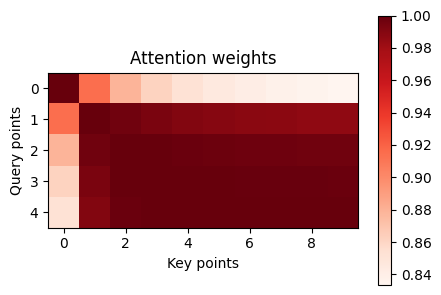

In [13]:
consim = torch.matmul(queries, keys.T) / torch.sqrt(
    queries.square().sum(axis=1, keepdims=True) *
    keys.square().sum(axis=1, keepdims=True).T
)
print(consim)
show_attention(consim)

tensor([[0.1137, 0.1044, 0.1007, 0.0990, 0.0981, 0.0975, 0.0970, 0.0967, 0.0965,
         0.0963],
        [0.0934, 0.1017, 0.1013, 0.1010, 0.1007, 0.1006, 0.1005, 0.1004, 0.1003,
         0.1002],
        [0.0898, 0.1010, 0.1014, 0.1013, 0.1012, 0.1012, 0.1011, 0.1011, 0.1010,
         0.1010],
        [0.0883, 0.1008, 0.1014, 0.1014, 0.1014, 0.1014, 0.1014, 0.1013, 0.1013,
         0.1013],
        [0.0875, 0.1006, 0.1014, 0.1015, 0.1015, 0.1015, 0.1015, 0.1015, 0.1015,
         0.1015]])


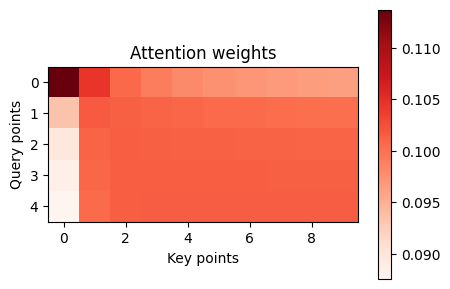

In [14]:
attention_weights = F.softmax(
    torch.matmul(
        queries, 
        keys.T
    ).div(torch.sqrt(
        queries.square().sum(axis=1, keepdims=True) *
        keys.square().sum(axis=1, keepdims=True).T
    )), 
    dim=1
)
print(attention_weights)
show_attention(attention_weights)

In [15]:
new_values = torch.matmul(
    attention_weights, 
    values.to(torch.float32)
)
new_values

tensor([[ 8.7607,  9.7607],
        [ 9.0456, 10.0456],
        [ 9.0986, 10.0986],
        [ 9.1202, 10.1202],
        [ 9.1319, 10.1319]])

In [16]:
def attention_DotProduct(queries, keys):
    """
    多元注意力回归

    Parameters
    ----------
    @param queries: torch.Tensor
        queries, shape (m, d)
    @param keys: torch.Tensor
        keys, shape (n, d)
    @returns: torch.Tensor
        attention_weights, shape (m, n)
    """
    d = queries.shape[-1]

    return F.softmax(
        torch.matmul(
            queries, 
            keys.T
        ).div(
            torch.sqrt(
                torch.tensor(d)
                .to(torch.float32)
            )
        ), 
        dim=1
    )

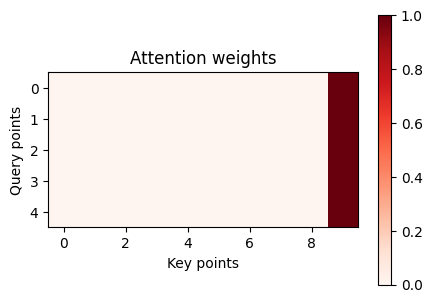

In [17]:
show_attention(attention_DotProduct(queries, keys))